In [81]:
import numpy as np
import torch.nn as nn
import torch

class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 256)
        self.fc = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [107]:
import torch
import nvtx
import time
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Parameters to feed into dataset loading
data_dir = 'data/'
raw_input_dir = 'raw/'
symbol = 'TSLA'
interval = '1h'
year = '2020'

filename = f'{symbol}_{year}_{interval}.csv'
csv_file = data_dir + raw_input_dir + filename

import pandas as pd
raw_data = pd.read_csv(csv_file)
# TODO (sahil.ramani): If the file data is reversed, reverse it.
# Reverse the data frame since we get the data backwards
raw_data = raw_data[::-1].reset_index(drop=True)

# Create a new index column
raw_data.reset_index(level=0, inplace=True)

In [108]:
raw_data

,index,datetime,open,high,low,close,volume
0,0,2020-01-03 09:00:00,88.08100,90.80000,87.65000,89.32000,6238189
1,1,2020-01-03 10:00:00,89.30400,90.23600,88.85800,89.86000,2881424
2,2,2020-01-03 11:00:00,89.82800,90.02800,89.35326,89.70000,1606110
3,3,2020-01-03 12:00:00,89.71000,89.84000,88.93800,89.28000,1443356
4,4,2020-01-03 13:00:00,89.27100,89.35000,88.17600,89.12000,1727566
...,...,...,...,...,...,...,...
1691,1691,2020-12-30 11:30:00,682.39301,686.98999,679.35999,684.17902,6427560
1692,1692,2020-12-30 12:30:00,684.39001,687.50000,682.09998,687.28998,3820709
1693,1693,2020-12-30 13:30:00,687.25690,694.70001,685.20001,694.28003,5853785
1694,1694,2020-12-30 14:30:00,694.31000,696.59998,687.72009,690.65002,7485556


In [109]:
import math
def split_counts(data_len, seq_length, train_per, val_per):
    remain_len = data_len
    train_count = math.floor(remain_len * train_per / seq_length) * seq_length
    remain_len -= train_count
    val_count = math.floor(remain_len * (val_per / (1.0 - train_per)) / seq_length) * seq_length
    remain_len -= val_count
    test_count = math.floor(remain_len / seq_length) * seq_length
    return (train_count, val_count, test_count)

from torch.utils.data import (TensorDataset, DataLoader)
def create_dataloader(data, lookback, bs):
    x = [data[i:i+lookback, :] for i in range(len(data)-lookback)]
    y = [[data[i, 0]] for i in range(lookback, len(data))]
    ds = TensorDataset(torch.as_tensor(x).float().to(device), torch.as_tensor(y).float().to(device))
    loader = DataLoader(ds, shuffle=False, batch_size=bs)
    return loader

In [110]:
features = ['close', 'volume']
input_size = len(features) #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers
num_classes = 1 #number of output classes 

seq_length = 20
train_per = 0.8
val_per = 0.1
batch_size = 100

train_count, val_count, test_count = split_counts(raw_data.shape[0], seq_length, train_per, val_per)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# 'close' is required and must be on index 0, everything else is optional
features = ['close', 'volume']
data = scaler.fit_transform(raw_data[features].values[:])
loader = create_dataloader(data, seq_length, batch_size)

In [111]:
lstm = LSTM1(num_classes, input_size, hidden_size, num_layers, seq_length)

ckpt_filename = 'stock/stocklearner_e0xxx_lr0.005.pth'
lstm.load_state_dict(torch.load(ckpt_filename))

# If we trained on GPU and wish to transfer the loaded model to GPU, 
# let's move the contents to the intended device.
lstm.to(device)

LSTM1(
  (lstm): LSTM(2, 2, batch_first=True)
  (fc_1): Linear(in_features=2, out_features=256, bias=True)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)

In [112]:
predictions = np.array(data[:seq_length, 0])
print(len(predictions))
lstm.eval()
for x_tensor, _ in loader:
    prediction = lstm.forward(x_tensor)
    predictions = np.append(predictions, prediction.squeeze(-1).detach().cpu().numpy())
    
print(len(predictions))

20
1696


In [113]:
p2 = np.concatenate((np.expand_dims(predictions, axis=1), np.expand_dims(data[:,1].T, axis=1)), axis=1)

In [114]:
predictions = scaler.inverse_transform(p2)[:,[0]].squeeze()
predictions

array([ 89.32      ,  89.86      ,  89.7       , ..., 686.27590393,
       692.70897879, 690.10146536])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

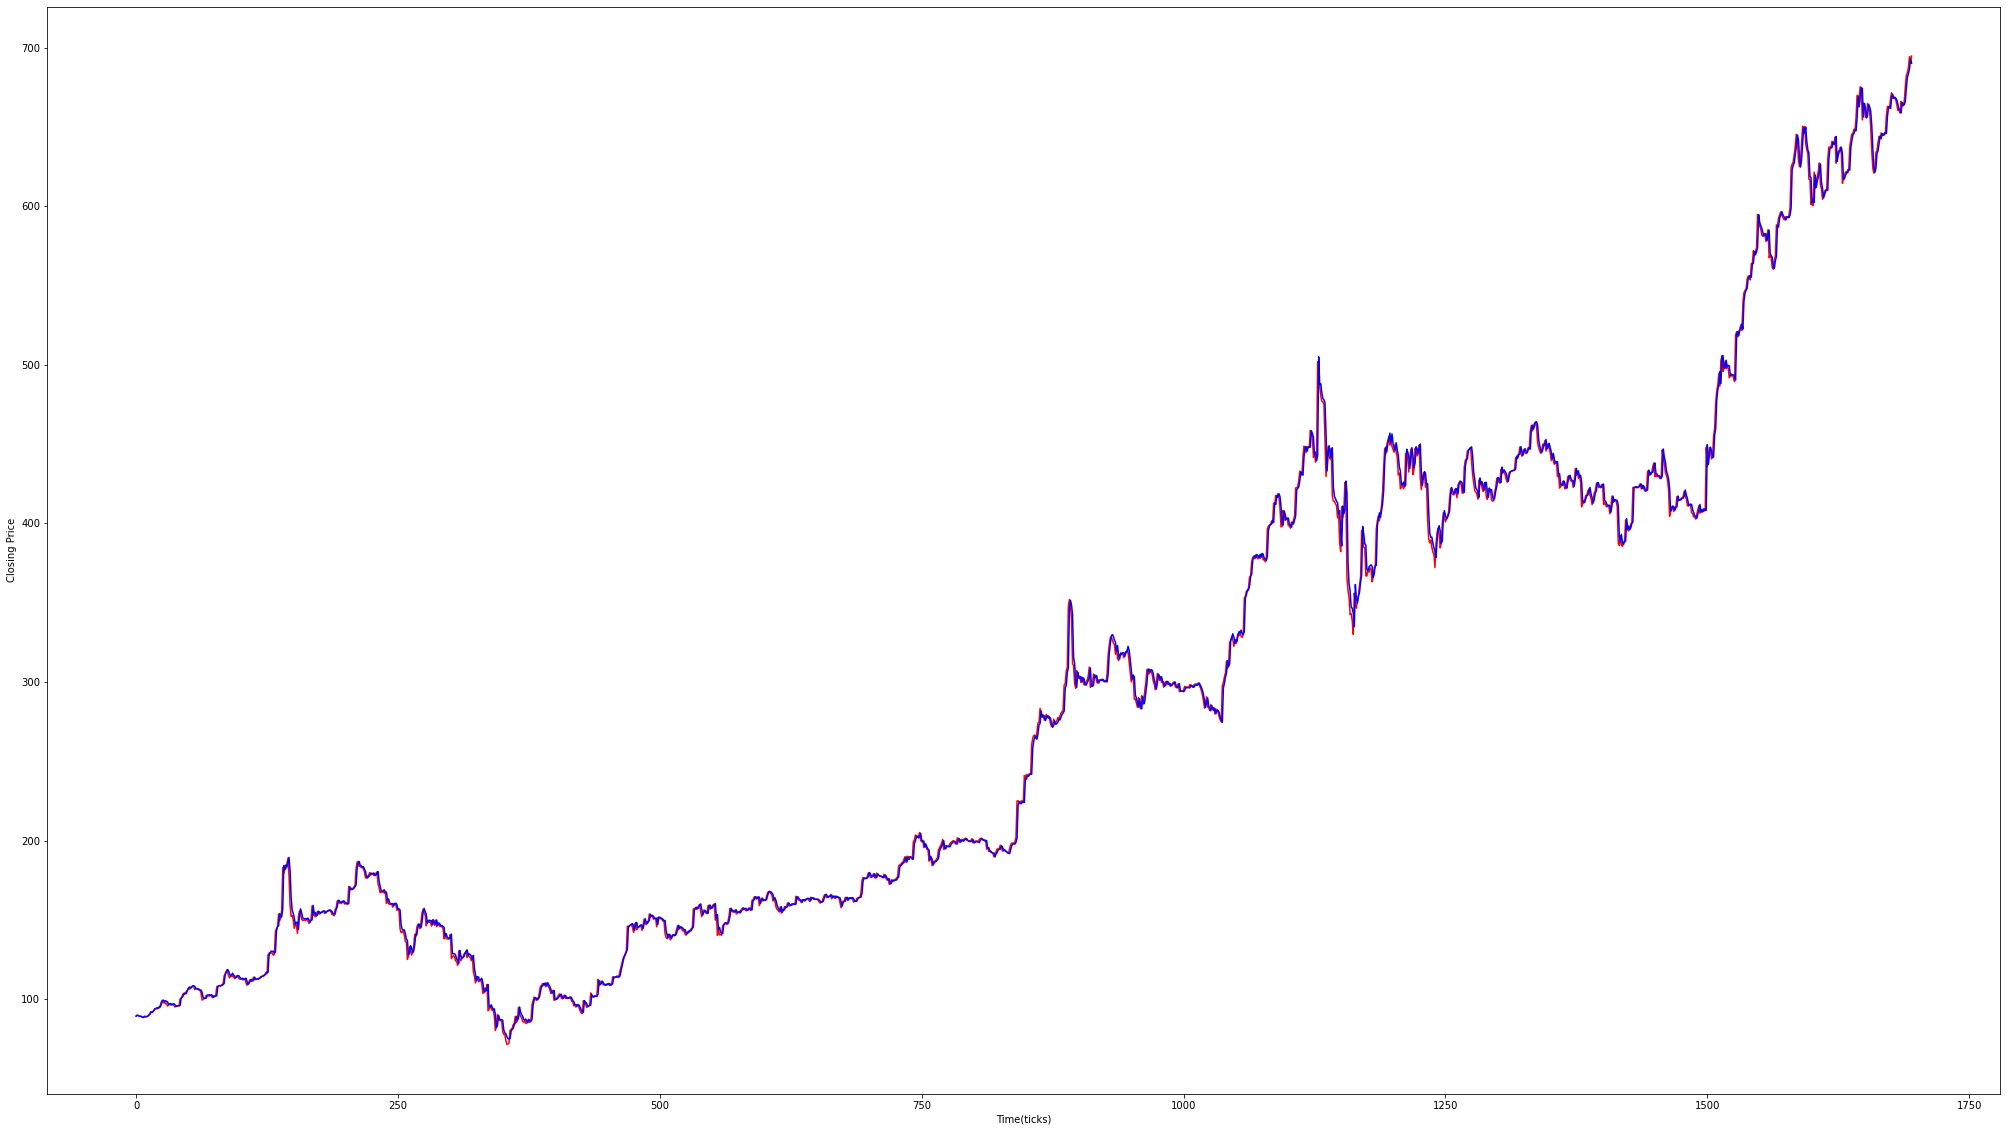

In [115]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib widget

# plt.plot('datetime', 'open', data=df)
fig, ax = plt.subplots()
fig.set_size_inches(35, 20)
ax.set_xlabel('Time(ticks)')
ax.set_ylabel('Closing Price')
ax.plot(raw_data['close'], color='red')
ax.plot(predictions, color='blue')

plt.show()